In [1]:
# --- LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
from IPython.display import display

In [2]:
# Load the Excel file
file_path = "../data/online_retail_II.xlsx"
df_2010 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
df = pd.concat([df_2010, df_2009], ignore_index=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [3]:
# ========== SECTION 1: Analyze Negative Transactions ==========
df_negative = df[df['Quantity'] < 0].copy()
df_negative['ReturnValue'] = df_negative['Quantity'] * df_negative['Price']
df_negative['Month'] = df_negative['InvoiceDate'].dt.to_period('M')
df_negative['InvoicePrefix'] = df_negative['Invoice'].astype(str).str[0]

top_returned_products = df_negative.groupby('Description')['Quantity'].sum().abs().sort_values(ascending=False).head(10)
returns_by_country = df_negative['Country'].value_counts().head(10)
monthly_returns = df_negative.groupby('Month')['Quantity'].sum().abs().sort_values(ascending=False)
top_returning_customers = df_negative['Customer ID'].dropna().astype(int).value_counts().head(10)

In [4]:
# ========== SECTION 2: Clean the Data ==========
df_clean = df.copy()
df_clean.dropna(subset=['Customer ID'], inplace=True)
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)].copy()
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')

In [5]:
# ========== SECTION 3: Core EDA ==========
monthly_sales = df_clean.groupby('Month')['TotalPrice'].sum()
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_customers = df_clean.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_countries = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

In [6]:
# ========== SECTION 4: High-Returning Customers ==========
df_sales = df_clean.copy()
df_returns = df[df['Quantity'] < 0].copy()
df_sales['PurchaseValue'] = df_sales['Quantity'] * df_sales['Price']
df_returns['ReturnValue'] = df_returns['Quantity'] * df_returns['Price']

cust_ret_summary = df_returns.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'ReturnValue': 'sum'
}).rename(columns={'Invoice': 'ReturnInvoices', 'Quantity': 'TotalUnitsReturned'})

cust_pur_summary = df_sales.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'PurchaseValue': 'sum'
}).rename(columns={'Invoice': 'PurchaseInvoices', 'Quantity': 'TotalUnitsPurchased'})

customer_behavior = pd.merge(cust_ret_summary, cust_pur_summary, on='Customer ID', how='inner')
customer_behavior['ReturnRateUnits'] = abs(customer_behavior['TotalUnitsReturned']) / (customer_behavior['TotalUnitsPurchased'] + 1)
customer_behavior['ReturnRateValue'] = abs(customer_behavior['ReturnValue']) / (customer_behavior['PurchaseValue'] + 1)

top_returners_units = customer_behavior.sort_values(by='ReturnRateUnits', ascending=False).head(10)
top_returners_value = customer_behavior.sort_values(by='ReturnValue', ascending=False).head(10)

In [7]:
# Deep dive on top returner
top_customer_id = top_returners_units.index[0]
cust_returns = df_negative[df_negative['Customer ID'] == top_customer_id].copy()
cust_returns['Month'] = cust_returns['InvoiceDate'].dt.to_period('M')
top_returned_items_by_customer = cust_returns.groupby('Description')['Quantity'].sum().abs().sort_values(ascending=False)
customer_monthly_returns = cust_returns.groupby('Month')['Quantity'].sum().abs()

In [8]:
# ========== SECTION 5: Visualizations (Formatted Axes) ==========
sns.set(style="whitegrid")
plt.rcParams['figure.autolayout'] = True
# Turn off future warnings (Seaborn palette warning)
warnings.filterwarnings("ignore", category=FutureWarning)

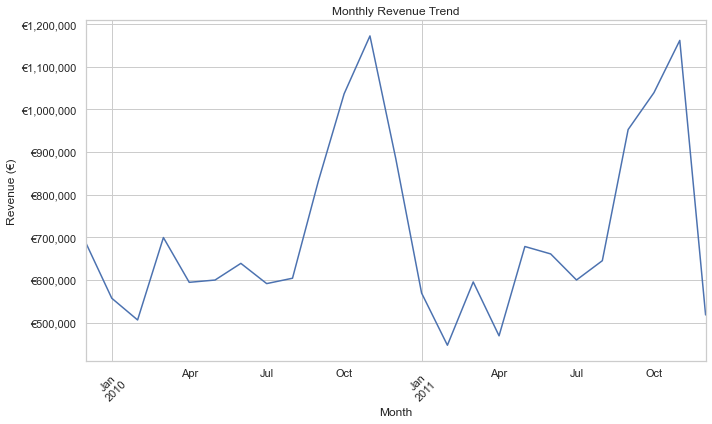

In [9]:
# Monthly revenue trend
fig, ax = plt.subplots(figsize=(10, 6))
monthly_sales.plot(kind='line', ax=ax)
ax.set_title("Monthly Revenue Trend")
ax.set_ylabel("Revenue (€)")
ax.set_xlabel("Month")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

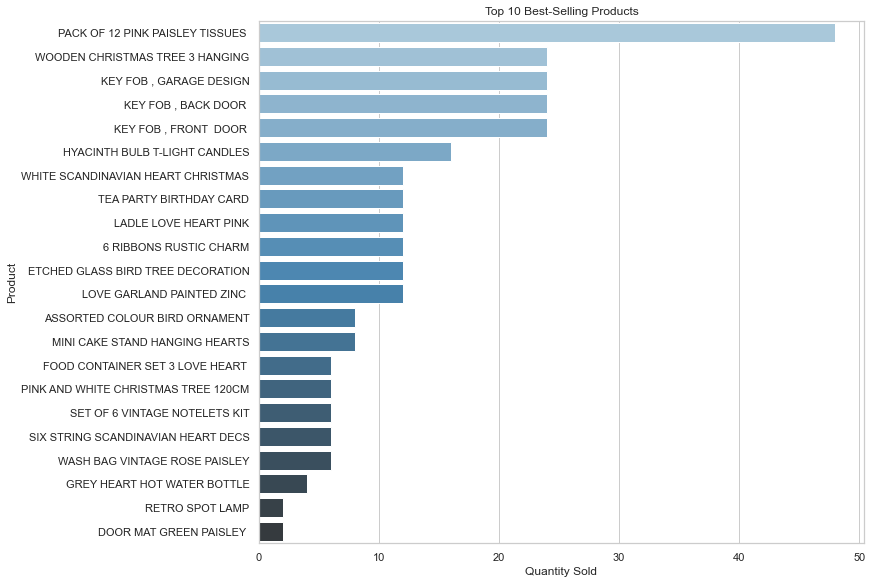

In [10]:
# Top products
fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")
sns.barplot(x=top_returned_items_by_customer.values, y=top_returned_items_by_customer.index, palette="Blues_d", legend=False)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.show()

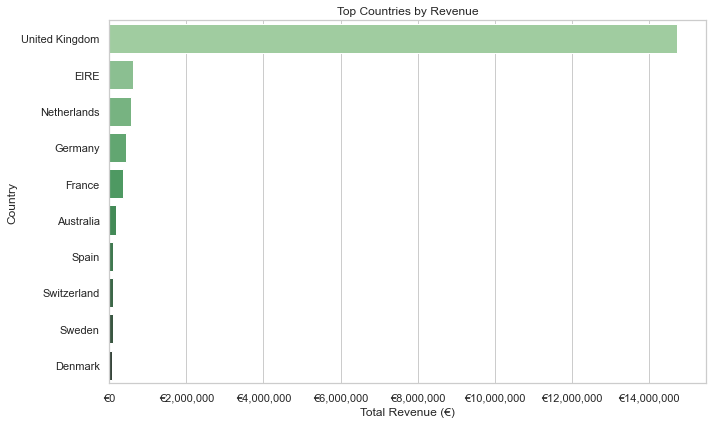

In [11]:
# Top countries by revenue
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index,ax=ax, palette="Greens_d", legend=False)
ax.set_title("Top Countries by Revenue")
ax.set_xlabel("Total Revenue (€)")
ax.set_ylabel("Country")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
plt.show()

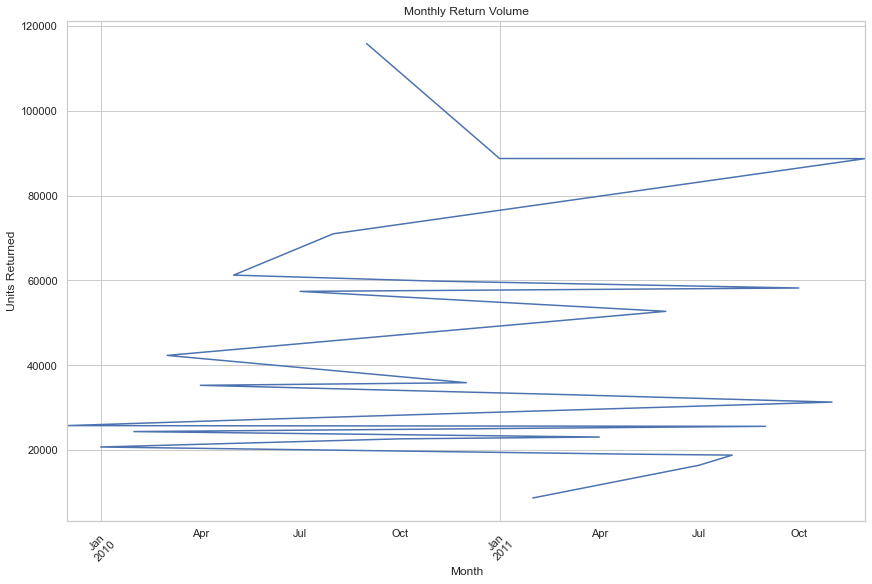

In [12]:
# Monthly returns trend
fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")
monthly_returns.plot(kind='line', title='Monthly Return Volume')
plt.ylabel("Units Returned")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()

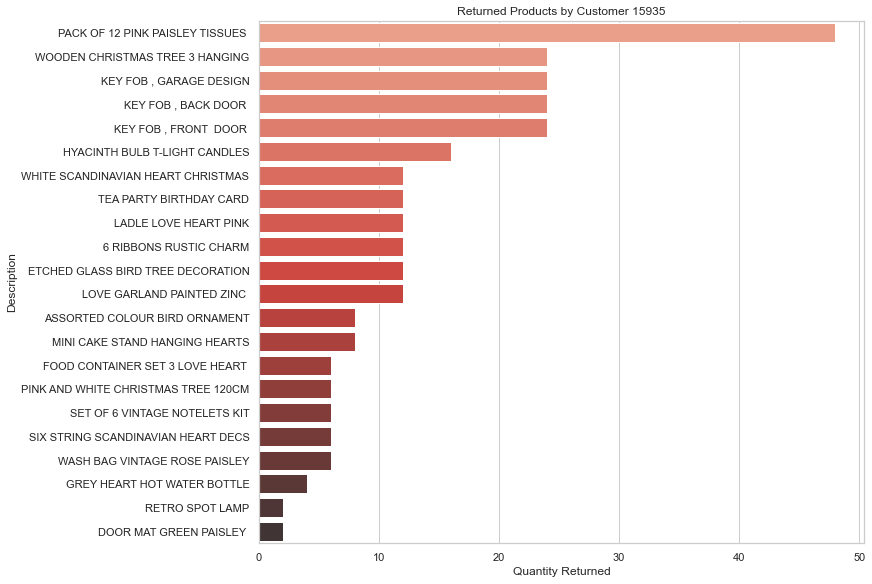

In [13]:
# Returned items by top returner

fig, ax = plt.subplots(figsize=(12, 8), layout="constrained")
sns.barplot(x=top_returned_items_by_customer.values, y=top_returned_items_by_customer.index, palette="Reds_d", legend=False)
plt.title(f"Returned Products by Customer {int(top_customer_id)}")
plt.xlabel("Quantity Returned")
plt.show()

In [14]:
# ========== SECTION 6: Table Formatting and Display ==========

def format_display_table(df, monetary_cols=None, fix_customer_id=False):
    df = df.reset_index(drop=True)
    df.index += 1
    if monetary_cols:
        for col in monetary_cols:
            df[col] = df[col].astype(float).apply(lambda x: f"€{x:,.2f}")
    if fix_customer_id and "Customer ID" in df.columns:
        df["Customer ID"] = df["Customer ID"].astype("Int64")
    return df

In [15]:
# Format all tables
top_returned_products_display = format_display_table(top_returned_products.reset_index(name='Total Units Returned'))
returns_by_country_display = format_display_table(returns_by_country.reset_index(name='Return Count'))
monthly_returns_display = format_display_table(monthly_returns.reset_index(name='Units Returned'))
top_returning_customers_display = format_display_table(top_returning_customers.reset_index(name='Return Count'), fix_customer_id=True)
top_products_display = format_display_table(top_products.reset_index(name='Quantity Sold'))
top_customers_display = format_display_table(top_customers.reset_index(name='Total Spent'), monetary_cols=['Total Spent'], fix_customer_id=True)
top_countries_display = format_display_table(top_countries.reset_index(name='Revenue (€)'), monetary_cols=['Revenue (€)'])
top_returners_units_display = format_display_table(top_returners_units.reset_index(), fix_customer_id=True)
top_returners_value_display = format_display_table(top_returners_value.reset_index(), fix_customer_id=True)
top_returned_items_by_customer_display = format_display_table(top_returned_items_by_customer.reset_index(name='Total Units Returned'))
customer_monthly_returns_display = format_display_table(customer_monthly_returns.reset_index(name='Units Returned'))


In [16]:
# Display Top Returned Products

print("\nTop Returned Products:")
display(top_returned_products_display)


Top Returned Products:


,Description,Total Units Returned
1,"PAPER CRAFT , LITTLE BIRDIE",80995
2,MEDIUM CERAMIC TOP STORAGE JAR,74494
3,?,37641
4,given away,20000
5,printing smudges/thrown away,19200
6,ROTATING SILVER ANGELS T-LIGHT HLDR,18750
7,missing,16467
8,"Unsaleable, destroyed.",15644
9,ebay sales,13630
10,check,13329


In [17]:
# Display Returns by Country

print("\nReturns by Country:")
display(returns_by_country_display)


Returns by Country:


,Country,Return Count
1,United Kingdom,20106
2,Germany,921
3,EIRE,512
4,France,389
5,USA,126
6,Australia,98
7,Japan,97
8,Channel Islands,95
9,Spain,91
10,Italy,66


In [18]:
 #Display Monthly Returns Volume

print("\nMonthly Returns Volume:")
display(monthly_returns_display)


Monthly Returns Volume:


,Month,Units Returned
1,2010-09,115846
2,2011-01,88750
3,2011-12,88719
4,2010-08,71000
5,2010-05,61253
6,2010-11,59849
7,2011-10,58213
8,2010-07,57415
9,2011-06,52714
10,2010-03,42319


In [19]:
 #Display Top Returning Customers

print("\nTop Returning Customers:")
display(top_returning_customers_display)


Top Returning Customers:


,Customer ID,Return Count
1,14911,366
2,15311,283
3,17511,223
4,17841,207
5,13798,192
6,14680,166
7,12471,160
8,14606,143
9,12472,138
10,14527,136


In [20]:
 #Display Top Products After Cleaning

print("\nTop Products After Cleaning:")
display(top_products_display)


Top Products After Cleaning:


,Description,Quantity Sold
1,WORLD WAR 2 GLIDERS ASSTD DESIGNS,109169
2,WHITE HANGING HEART T-LIGHT HOLDER,93640
3,"PAPER CRAFT , LITTLE BIRDIE",80995
4,ASSORTED COLOUR BIRD ORNAMENT,79913
5,MEDIUM CERAMIC TOP STORAGE JAR,77916
6,JUMBO BAG RED RETROSPOT,75759
7,BROCADE RING PURSE,71129
8,PACK OF 60 PINK PAISLEY CAKE CASES,55270
9,60 TEATIME FAIRY CAKE CASES,53495
10,PACK OF 72 RETROSPOT CAKE CASES,46107


In [21]:
 #Display Top Customers After Customers After Cleaning

print("\nTop Customers After Cleaning:")
display(top_customers_display)


Top Customers After Cleaning:


,Customer ID,Total Spent
1,18102,"€608,821.65"
2,14646,"€528,602.52"
3,14156,"€313,946.37"
4,14911,"€295,972.63"
5,17450,"€246,973.09"
6,13694,"€196,482.81"
7,17511,"€175,603.55"
8,16446,"€168,472.50"
9,16684,"€147,142.77"
10,12415,"€144,458.37"


In [22]:
 #Display Top Countries by Revenue

print("\nTop Countries by Revenue:")
display(top_countries_display)


Top Countries by Revenue:


,Country,Revenue (€)
1,United Kingdom,"€14,723,147.52"
2,EIRE,"€621,631.11"
3,Netherlands,"€554,232.34"
4,Germany,"€431,262.46"
5,France,"€355,257.47"
6,Australia,"€169,968.11"
7,Spain,"€109,178.53"
8,Switzerland,"€100,365.34"
9,Sweden,"€91,549.72"
10,Denmark,"€69,862.19"


In [23]:
 #Display Top Returners by Unit Return Rate

print("\nTop Returners by Unit Return Rate:")
display(top_returners_units_display)


Top Returners by Unit Return Rate:


,Customer ID,ReturnInvoices,TotalUnitsReturned,ReturnValue,PurchaseInvoices,TotalUnitsPurchased,PurchaseValue,ReturnRateUnits,ReturnRateValue
1,15935,1,-286,-308.82,2,115,416.86,2.465517,0.739051
2,13776,6,-6,-964.15,2,2,623.98,2.000000,1.542689
3,14213,1,-488,-2384.40,1,244,1192.20,1.991837,1.998324
4,16252,1,-316,-590.18,1,158,295.09,1.987421,1.993245
5,13091,3,-2424,-2452.04,3,1339,2321.82,1.808955,1.055631
6,14255,3,-3,-2442.23,1,1,1000.63,1.500000,2.438256
7,14802,4,-4,-3005.96,2,2,1502.98,1.333333,1.998670
8,15202,5,-5,-8571.67,3,3,6001.49,1.250000,1.428019
9,15760,3,-3,-19712.21,2,2,13916.34,1.000000,1.416378
10,15354,4,-4,-379.20,3,3,284.40,1.000000,1.328662


In [24]:
 #Display Top Returners by Return Value

print("\nTop Returners by Return Value:")
display(top_returners_value_display)


Top Returners by Return Value:


,Customer ID,ReturnInvoices,TotalUnitsReturned,ReturnValue,PurchaseInvoices,TotalUnitsPurchased,PurchaseValue,ReturnRateUnits,ReturnRateValue
1,17334,1,-1,-0.42,3,566,635.15,0.001764,0.000660
2,16566,1,-1,-0.65,5,362,614.66,0.002755,0.001056
3,14094,1,-1,-0.95,1,177,335.22,0.005618,0.002826
4,17530,1,-1,-0.95,12,1965,3141.51,0.000509,0.000302
5,17164,1,-1,-0.95,7,1501,2467.35,0.000666,0.000385
6,17521,1,-1,-1.25,5,806,1278.06,0.001239,0.000977
7,16473,1,-1,-1.25,4,296,470.83,0.003367,0.002649
8,15682,1,-1,-1.25,2,222,318.24,0.004484,0.003916
9,17380,1,-1,-1.25,3,252,645.00,0.003953,0.001935
10,13433,1,-1,-1.45,4,190,658.32,0.005236,0.002199


In [25]:
 #Display Returned Products by Customer

print("\nReturned Products by Customer:")
display(top_returned_items_by_customer_display)


Returned Products by Customer:


,Description,Total Units Returned
1,PACK OF 12 PINK PAISLEY TISSUES,48
2,WOODEN CHRISTMAS TREE 3 HANGING,24
3,"KEY FOB , GARAGE DESIGN",24
4,"KEY FOB , BACK DOOR",24
5,"KEY FOB , FRONT DOOR",24
6,HYACINTH BULB T-LIGHT CANDLES,16
7,WHITE SCANDINAVIAN HEART CHRISTMAS,12
8,TEA PARTY BIRTHDAY CARD,12
9,LADLE LOVE HEART PINK,12
10,6 RIBBONS RUSTIC CHARM,12


In [26]:
 #Display Monthly Returns by Customer

print("\nMonthly Returns by Customer:")
display(customer_monthly_returns_display)


Monthly Returns by Customer:


,Month,Units Returned
1,2009-12,286


In [27]:
# Create and format Monthly Sales for export
monthly_sales_df = monthly_sales.reset_index()
monthly_sales_df.columns = ['Month', 'Revenue (€)']
monthly_sales_df['Revenue (€)'] = monthly_sales_df['Revenue (€)'].round(2)
monthly_sales_df.index += 1

In [28]:
# ✅ Export cleaned data for Tableau to repo's data folder
excel_export_path = "../data/For_Tableau_online_retail_II.xlsx"

with pd.ExcelWriter(excel_export_path, engine='xlsxwriter') as writer:
    top_returned_products_display.to_excel(writer, sheet_name='Top_Returned_Products', index_label='Index')
    returns_by_country_display.to_excel(writer, sheet_name='Returns_by_Country', index_label='Index')
    monthly_returns_display.to_excel(writer, sheet_name='Monthly_Returns', index_label='Index')
    top_returning_customers_display.to_excel(writer, sheet_name='Top_Returning_Customers', index_label='Index')
    top_products_display.to_excel(writer, sheet_name='Top_Products', index_label='Index')
    top_customers_display.to_excel(writer, sheet_name='Top_Customers', index_label='Index')
    top_countries_display.to_excel(writer, sheet_name='Revenue_by_Country', index_label='Index')
    top_returners_units_display.to_excel(writer, sheet_name='Returners_by_UnitRate', index_label='Index')
    top_returners_value_display.to_excel(writer, sheet_name='Returners_by_Value', index_label='Index')
    top_returned_items_by_customer_display.to_excel(writer, sheet_name='Returned_Items_by_Customer', index_label='Index')
    customer_monthly_returns_display.to_excel(writer, sheet_name='Monthly_Returns_by_Customer', index_label='Index')
    monthly_sales_df.to_excel(writer, sheet_name='Monthly_Sales', index_label='Index')
